# Prática 2

## Inferência Bayesiana

***Estatística para Ciência de Dados***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**




## Aplicação

Traduzida e adaptada de https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb


Suponha que visitemos uma reserva de animais selvagens onde sabemos que os únicos animais são **leões, tigres e ursos**, mas não sabemos quantos de cada há nesse local. Durante o passeio, vemos **3 leões, 2 tigres e 1 urso**. Supondo que todos os animais tenham chances iguais de aparecer em nossa amostra, estime a prevalência de cada espécie. Qual é a probabilidade de o próximo animal que vemos ser um urso?

**Modelo**

O modelo subjacente é **multinomial** com parâmetros $ p_k $ (veja, por exemplo, https://en.wikipedia.org/wiki/Multinomial_distribution).

A distribuição a priori de $ p_k $ é uma **distribuição Dirichlet** (veja, por exemplo, https://en.wikipedia.org/wiki/Dirichlet_distribution).

O vetor $ \alpha $ é um parâmetro da distribuição a priori de Dirichlet, também chamado de **hiperparâmetro de concentração**.

Uma Distribuição Multinomial com uma Priori de Dirichlet é referida como uma Distribuição Multinomial de Dirichlet.


O modelo pode ser expresso em equações como:


$${\begin{array}{lclcl}{\boldsymbol {\alpha }}=(\alpha _{1},\ldots ,\alpha _{K})  =  {\text{hiperparâmetros de concentração}}\\\mathbf {p} \mid {\boldsymbol {\alpha }}  =  (p_{1},\ldots ,p_{K})  \sim   \operatorname {Dir} (K,{\boldsymbol {\alpha }})\\\mathbb {X} \mid \mathbf {p}   =  (x_{1},\ldots ,x_{K})  \sim   \operatorname {Mult} (K,\mathbf {p} )\end{array}}$$

Nosso objetivo é estimar $p_\text{leões}$, $p_\text{tigres}$, $p_\text{ursos}$ dado o vetor observado $c = [c_{leões}, c_{tigres}, c_{ursos}]$


**Distribuição Multinomial**

Este problema é um exemplo clássico da distribuição multinomial que descreve uma situação em que temos n tentativas independentes, cada uma com k resultados possíveis. Neste problema, $n = 6$ e $k = 3$. Caracterizado pela probabilidade de cada resultado, $ p_k $ que deve somar 1. Nosso objetivo é encontrar $ p_ \text {leões} $, $ p_ \text{tigres} $, $ p_ \text{ursos} $ dadas as observações $c_{leões}= 3$, $c_{tigres}= 2$ e $c_{ursos}= 1$.

**Distribuição Dirichlet**

Uma distribuição multinomial com uma priori Dirichlet é chamada de modelo Dirichlet-Multinomial. A distribuição de Dirichlet é caracterizada por $ \alpha $, o vetor dos hiperparâmetros de concentração.

**Hiperparâmetros**

O vetor $\alpha $ é o hiperparâmetro, um parâmetro de uma distribuição a priori. 

O vetor hiperparâmetro pode ser considerado como pseudo-contagens, que usamos para mostrar nossa crença a priori para a prevalência de cada espécie. Se quisermos um hiperparâmetro uniforme refletindo que acreditamos que a chance de observar qualquer espécie é a mesma, definimos cada elemento de alfa igual, como $ \alpha = [1, 1, 1] $. Podemos aumentar ou diminuir o efeito das a prioris aumentando ou diminuindo os valores. Isso pode ser útil quando temos mais ou menos confiança em nossas crenças a prioris. 


Instale os pacotes abaixo se necessário.

In [1]:
#!pip install pymc3==3.11.1

In [2]:
#!pip show pymc3

In [3]:
#!pip install arviz==0.11.2

In [4]:
#!pip show arviz

In [5]:
import pandas as pd
import numpy as np
import arviz as az


# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline

from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc3 as pm

# ATENÇÃO!
# Carregue o modulo utils.py disponível no moodle para esta aplicação
import utils

# Helper functions
from utils import display_probs


## Especificidades do problema

Usaremos principalmente uma versão dos hiperparâmetros, $ \alpha = [1, 1, 1] $, que são os parâmetros da Dirichlet. Teste outros valores para ver como isso muda a solução do problema. Lembre-se que alterar os hiperparâmetros é inserir conhecimentos diferentes a respeito das distribuições a priori.

In [6]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

## Expected Value

Fonte: http://users.cecs.anu.edu.au/~ssanner/MLSS2010/Johnson1.pdf


Uma maneira de obter uma estimativa pontual da prevalência é usar o valor esperado da posteriori para $ p_k $. O valor esperado de uma Distribuição Multinomial de Dirichlet é:
$${\displaystyle \operatorname {E} [p_{i}\mid \mathbb {X} ,{\boldsymbol {\alpha }}]={\frac {c_{i}+\alpha _{i}}{N+\sum _{k}\alpha _{k}}}}$$


In [7]:
display_probs(dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum()))))

Species: lions    Prevalence: 44.44%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 22.22%.


## Modelo Bayesiano
Usaremos o PYMC3 e parâmetro $\alpha = [1, 1, 1]$ para a priori.
A verossimilhança é multinomial e a priori para os parâmetros é Dirichlet.

In [8]:
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)

## Amostrando do modelo

A célula abaixo mostra 1000 amostras da posteriori em 2 cadeias. Usamos 500 amostras para ajuste que são descartadas. Isso significa que para cada variável aleatória do modelo - os parâmetros - teremos 2.000 valores retirados da distribuição posterior.


In [9]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.


In [10]:
summary = pm.summary(trace)
summary.index = animals
summary

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lions,0.447,0.161,0.161,0.753,0.005,0.003,1245.0,1104.0,1.0
tigers,0.330,0.151,0.061,0.599,0.004,0.003,1209.0,781.0,1.0
bears,0.224,0.132,0.003,0.459,0.003,0.002,1471.0,1153.0,1.0


## Inspecionando os resultados

Análise dos resultados com PYMC3:


In [11]:
summary = az.summary(trace)
summary.index = animals
summary

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lions,0.447,0.161,0.161,0.753,0.005,0.003,1245.0,1104.0,1.0
tigers,0.330,0.151,0.061,0.599,0.004,0.003,1209.0,781.0,1.0
bears,0.224,0.132,0.003,0.459,0.003,0.002,1471.0,1153.0,1.0


In [12]:

# Samples
trace_df = pd.DataFrame(trace['parameters'], columns = animals)
trace_df.head()

,lions,tigers,bears
0,0.276776,0.400420,0.322805
1,0.333723,0.489212,0.177065
2,0.575969,0.335053,0.088977
3,0.450776,0.371659,0.177565
4,0.644207,0.212555,0.143239


Podemos perceber que a média das amostras está muito próxima do valor esperado, mas também devemos observar asestimativas intervalares.

In [13]:
# For probabilities use samples after burn in
pvals = trace_df.iloc[:, :3].mean(axis = 0)
display_probs(dict(zip(animals, pvals)))

Species: lions    Prevalence: 44.65%.
Species: tigers   Prevalence: 32.99%.
Species: bears    Prevalence: 22.36%.


## Gráficos de diagnóstico


Got error No model on context stack. trying to find log_likelihood in translation.


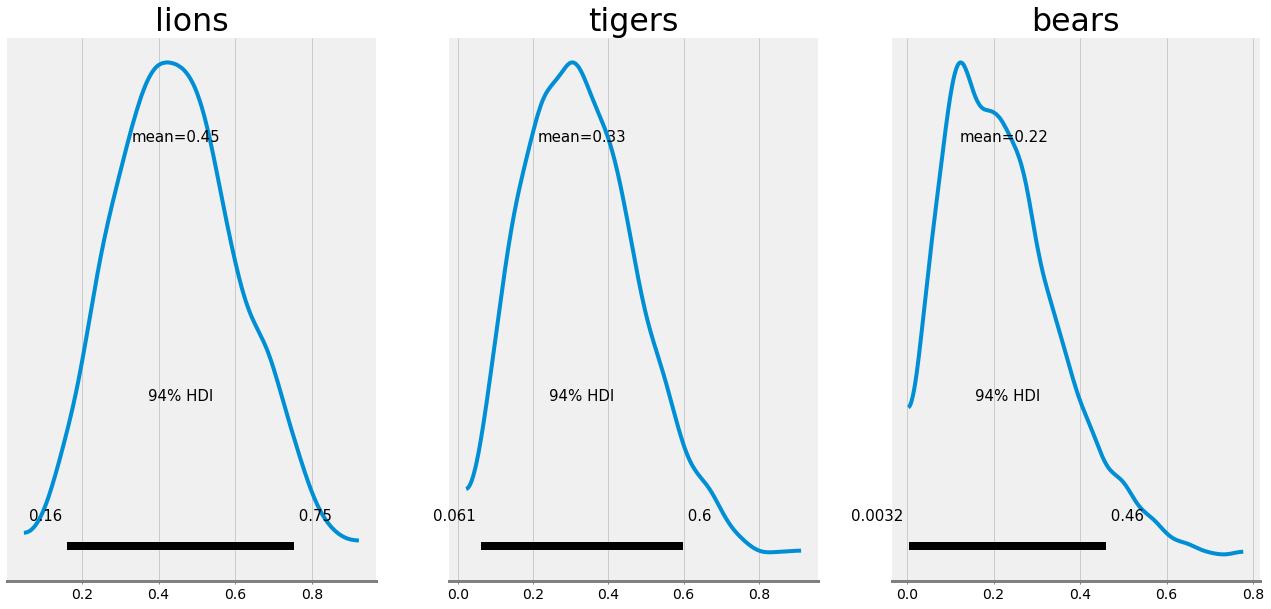

In [14]:
#ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       #figsize = (20, 10), edgecolor = 'k');

ax = az.plot_posterior(trace, figsize = (20, 10));


plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

## Traceplot

The traceplot shows a kernel density estimate (a smoothed histogram) on the left and all the samples that were drawn on the right. We collapse the chains on th plots (combined = True) but in reality we drew 2 independent chains.


## Máximo a Posteriori usando PyMC3



In [15]:
with model:
    # Find the maximum a posteriori estimate
    map_ = pm.find_MAP()
    
display_probs(dict(zip(animals, map_['parameters'])))




Species: lions    Prevalence: 50.00%.
Species: tigers   Prevalence: 33.33%.
Species: bears    Prevalence: 16.67%.


## Próxima observação

Para predizer uma próxima observação, extraímos uma única amostra 10.000 vezes de uma distribuição multinomial. A probabilidade de ver cada espécie é proporcional à obtida na amostragem.


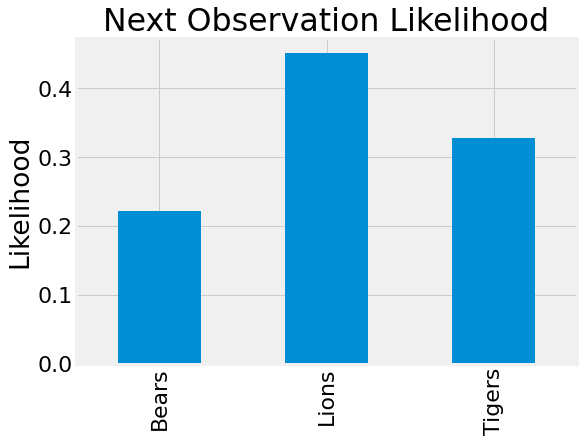

In [16]:
# Draw from the multinomial
next_obs = np.random.multinomial(n = 1, pvals = pvals, size = 10000)

# Data manipulation
next_obs = pd.melt(pd.DataFrame(next_obs, columns = ['Lions', 'Tigers', 'Bears'])).\
            groupby('variable')['value'].\
            value_counts(normalize=True).to_frame().\
             rename(columns = {'value': 'total'}).reset_index()
next_obs = next_obs.loc[next_obs['value'] == 1]

# Bar plot
next_obs.set_index('variable')['total'].plot.bar(figsize = (8, 6));
plt.title('Next Observation Likelihood');
plt.ylabel('Likelihood'); plt.xlabel('');

In [17]:
next_obs.iloc[:, [0, 2]]

,variable,total
1,Bears,0.2222
3,Lions,0.4506
5,Tigers,0.3272


Qual a probabilidade do próximo animal ser um urso?

Se você tivesse que fazer uma previsão de qual seria o próximo animal observado, qual você escolheria?

Altere os hiperparâmetros para $\alpha = [0.1, 0.1, 0.1]$ e $\alpha = [15, 15, 15]$ e compare os resultados obtidos.

(Veja mais análises em  https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb)